In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io 
import scipy.optimize as sopt
from tensorflow.python.framework import ops
ops.reset_default_graph()
tf.keras.backend.set_floatx('float64')


In [2]:
# r = tf.convert_to_tensor(np.linspace(1, 4, 100), dtype=tf.float64)
# theta = tf.convert_to_tensor(np.linspace(0, np.pi/2, 100), dtype=tf.float64)
# R, Theta = tf.meshgrid(r, theta)
# X = R*tf.cos(Theta)
# Y = R*tf.sin(Theta)
# physical_nodes = tf.stack((tf.reshape(X, (-1,)), tf.reshape(Y, (-1,))), axis=1)

In [3]:
#gauss points
gauss_points = scipy.io.loadmat('/kaggle/input/model-weights/Gauss_pt.mat')['Gauss_pt_wt']
weights = tf.convert_to_tensor(np.prod(gauss_points[:,2:], axis=1), dtype=tf.float64)
gauss_points = tf.convert_to_tensor(gauss_points[:,:2], dtype=tf.float64)
right_boundary = tf.stack((np.ones((1000,)),np.linspace(0, 1,1000)), axis=1)

In [4]:
plot_X, plot_Y  = tf.meshgrid(tf.linspace(0,1,800), tf.linspace(0,1,800))
plot_nodes = tf.stack((tf.reshape(plot_X, (-1,)), tf.reshape(plot_Y, (-1,))), axis=1)

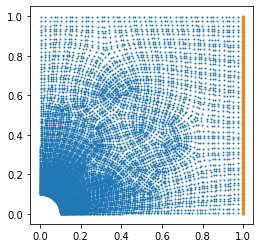

In [7]:
plt.figure(figsize=(4,4))
plt.scatter(gauss_points[:,0], gauss_points[:,1], s=1)
plt.scatter(right_boundary[:,0], right_boundary[:,1], s=1)
plt.show()

In [12]:
class PINN():
    def __init__(self, F, E, nu, layer_sizes, lb, ub, weights, activation, boundary):
        self.F = F
        self.E = tf.constant(E, dtype=tf.float64)
        self.nu= tf.constant(nu, dtype=tf.float64)
        self.loss = []
        self.weights = weights
        self.optimizer = tf.keras.optimizers.Adam()
        self.layer_sizes = layer_sizes
        self.lb = lb
        self.ub = ub
        self.x_axis = tf.convert_to_tensor([[1, 0]], dtype=tf.float64)
        self.y_axis = tf.convert_to_tensor([[0, 1]], dtype=tf.float64)
        self.W = []
        self.B = []
#         self.wj = tf.reduce_prod(wj, axis=1, keepdims=True)
        self.activation = activation
        self.boundary = boundary
        for i in range(len(layer_sizes)-1):
            self.W.append(self.xavier_init(size=[layer_sizes[i], layer_sizes[i + 1]]))
            self.B.append(tf.Variable(tf.zeros(shape=layer_sizes[i+1], dtype= tf.float64), trainable=True))  
        
    def call(self, x):
        y = self.preprocess(x)
        for i in range(len(self.W)-1):
            y = self.activation(tf.matmul(y, self.W[i]) + self.B[i])**2
        y = tf.matmul(y, self.W[-1]) + self.B[-1]
        return x*y
    
    def strain_matrix(self, x):
        with tf.GradientTape() as tape:
            tape.watch(x)
            u = self.call(x)
        strain = tf.reshape(tape.batch_jacobian(u, x), (x.shape[0], 4))
        return strain
    
    def strain(self, x):
        strain = self.strain_matrix(x)
        exx = strain[:,0]
        eyy = strain[:,3]
        exy = (strain[:,1] + strain[:,2])
        strain = tf.expand_dims(tf.stack([exx, eyy, exy], axis=1), 1)
        return strain
    
    def traction_work_done(self):
        work_done = tf.reduce_mean(self.F*self.call(self.boundary)[:,0])
        return work_done
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2.0 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64), dtype=tf.float64, trainable=True)
    
    def energy(self, x):
        strain = self.strain(x)
        elasticity_matrix = self.elasticity()
        point_wise_energy = tf.matmul(tf.matmul(strain, elasticity_matrix), strain, transpose_b = True)/2.0
        point_wise_energy = tf.squeeze(point_wise_energy)
        internal_energy = tf.reduce_sum(point_wise_energy*self.weights)
        work_done = self.traction_work_done()
        loss = internal_energy - work_done
        self.loss.append(loss)
        return loss
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            loss = self.energy(x)
        self.optimizer.minimize(loss, self.W + self.B, tape=tape) 
    
    def elasticity(self):
        C = tf.convert_to_tensor([[self.E/(1-self.nu**2), self.E*self.nu/(1-self.nu**2), 0],
                                  [self.E*self.nu/(1-self.nu**2),self.E/(1-self.nu**2), 0],
                                  [0, 0, self.E/(2*(1+self.nu))]], dtype=tf.float64)
        return C
    
    def preprocess(self, x):
        y = 2.0*(x-self.lb)/(self.ub-self.lb) - 1.0
        return y
    
    def grid_displacement(self, x, shape):
        u = self.call(x).numpy()
        condition = (x[:,0]**2 + x[:,1]**2) < 0.01    
        u[condition] = np.nan
        ux = np.reshape(u[:,0], shape)
        uy = np.reshape(u[:,1], shape)
        return ux, uy
    
    def grid_strain(self, x, shape):
        strain = self.strain(x).numpy()
        condition = (x[:,0]**2 + x[:,1]**2) < 0.01    
        strain[condition] = np.nan
        exx = np.reshape(strain[:,:,0], shape)
        eyy = np.reshape(strain[:,:,1], shape)
        exy = np.reshape(strain[:,:,2], shape)
        return exx, eyy, exy
    
    def grid_stress(self, x, shape):
        stress = tf.matmul(self.elasticity(x), self.strain(x), transpose_b=True).numpy()
        condition = (x[:,0]**2 + x[:,1]**2) < 0.01      
        stress[condition] = np.nan
        sxx = np.reshape(stress[:,0], shape)
        syy = np.reshape(stress[:,1], shape)
        sxy = np.reshape(stress[:,2], shape)
        return sxx, syy, sxy

In [13]:
pinn = PINN(F=10,
            E=1.0E3,
            nu=0.3,
            layer_sizes=[2,30,30,30,2],
            lb = tf.reduce_min(gauss_points, axis=0),
            ub = tf.reduce_max(gauss_points, axis=0),
            weights=weights,
            boundary=right_boundary,
            activation=tf.nn.relu)

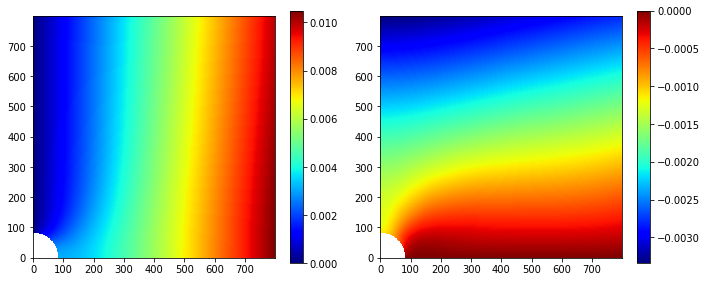

In [36]:
ux, uy = pinn.grid_displacement(plot_nodes, shape=(800,800))
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.imshow(ux, origin='lower', cmap='jet')
plt.colorbar()
# plt.title('Ux before training the model')
plt.subplot(1,2,2)
plt.imshow(uy, origin='lower', cmap='jet')
plt.colorbar()
# plt.title('Uy before training the model')
plt.tight_layout()
# plt.savefig('1.png')
plt.show()

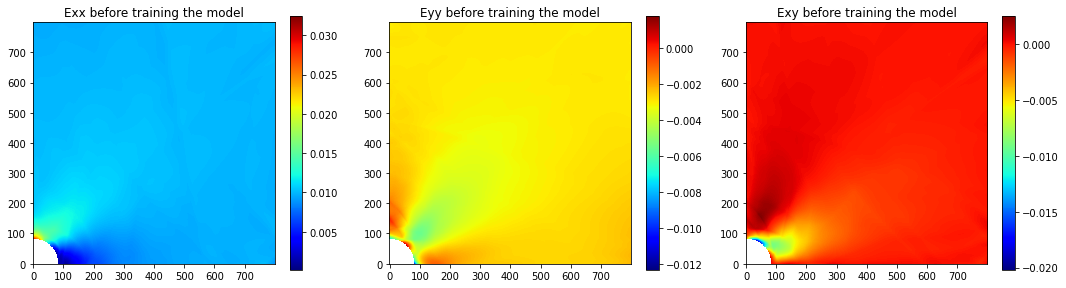

In [37]:
exx, eyy, exy = pinn.grid_strain(plot_nodes, shape=(800,800))
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.imshow(exx, origin='lower', cmap='jet')
plt.colorbar()
plt.title('Exx before training the model')
plt.subplot(1,3,2)
plt.imshow(eyy, origin='lower', cmap='jet')
plt.colorbar()
plt.title('Eyy before training the model')
plt.subplot(1,3,3)
plt.imshow(exy, origin='lower', cmap='jet')
plt.colorbar()
plt.title('Exy before training the model')
plt.tight_layout()
# plt.savefig('2.png')
plt.show()

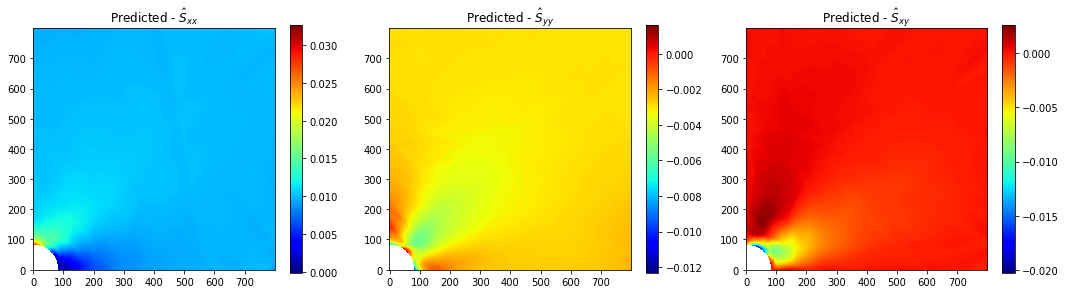

In [34]:
sxx, syy, sxy = pinn.grid_strain(plot_nodes, shape=(800,800))
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.imshow(sxx, origin='lower', cmap='jet')
plt.colorbar()
plt.title(r'Predicted - $\hat{S}_{xx}$')
plt.subplot(1,3,2)
plt.imshow(syy, origin='lower', cmap='jet')
plt.colorbar()
plt.title(r'Predicted - $\hat{S}_{yy}$')
plt.subplot(1,3,3)
plt.imshow(sxy, origin='lower', cmap='jet')
plt.colorbar()
plt.title(r'Predicted - $\hat{S}_{xy}$')
plt.tight_layout()
# plt.savefig('3.png')
plt.show()

In [35]:
for i in range(1000):
    pinn.train_step(gauss_points)
    if i%10 == 0:
        print('Epoch:\t{0}\tLoss:\t{1}'.format(i,pinn.loss[-1]))

Epoch:	0	Loss:	-0.05120872728831588
Epoch:	10	Loss:	-0.05120969470603554
Epoch:	20	Loss:	-0.05120708973121002
Epoch:	30	Loss:	-0.05120852064466197
Epoch:	40	Loss:	-0.051209546455056536
Epoch:	50	Loss:	-0.051208122684025276
Epoch:	60	Loss:	-0.05120870552183339
Epoch:	70	Loss:	-0.051209483177351425
Epoch:	80	Loss:	-0.051208850234064504
Epoch:	90	Loss:	-0.051207526093976136
Epoch:	100	Loss:	-0.05120786654625288
Epoch:	110	Loss:	-0.051209798115489424
Epoch:	120	Loss:	-0.05120967817448571
Epoch:	130	Loss:	-0.051208870049776575
Epoch:	140	Loss:	-0.051206646664836035
Epoch:	150	Loss:	-0.05120929140519109
Epoch:	160	Loss:	-0.05120919093221169
Epoch:	170	Loss:	-0.05120970241471658
Epoch:	180	Loss:	-0.05120965321621539
Epoch:	190	Loss:	-0.05120940629539325
Epoch:	200	Loss:	-0.05120525366134697
Epoch:	210	Loss:	-0.05120919913492631
Epoch:	220	Loss:	-0.051209175196192454
Epoch:	230	Loss:	-0.05120898729465076
Epoch:	240	Loss:	-0.05121019786235639
Epoch:	250	Loss:	-0.05120996803967933
Epoch:	260	Los

KeyboardInterrupt: 

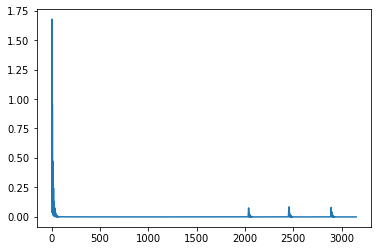

In [20]:
plt.plot(pinn.loss)

In [ ]:
pinn.energy(gauss_nodes)

In [ ]:
ux, uy = pinn.grid_displacement(physical_nodes, shape=(500,500))
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.imshow(ux, origin='lower', cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title('Ux after training the model')
plt.subplot(1,2,2)
plt.imshow(uy, origin='lower', cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title('Uy after training the model')
plt.tight_layout()
# plt.savefig('5.png')
plt.show()

In [ ]:
exx, eyy, exy = pinn.grid_strain(physical_nodes, shape=(500,500))
plt.figure(figsize=(15, 4))
plt.rcParams['font.size'] = 14
plt.subplot(1,3,1)
plt.imshow(exx, origin='lower', cmap='jet')
plt.colorbar()
# plt.axis('off')
plt.title('Exx after training the model')
plt.subplot(1,3,2)
plt.imshow(eyy, origin='lower', cmap='jet')
plt.colorbar()
# plt.axis('off')
plt.title('Eyy after training the model')
plt.subplot(1,3,3)
plt.imshow(exy, origin='lower', cmap='jet')
plt.colorbar()
# plt.axis('off')
plt.title('Exy after training the model')
plt.tight_layout()
# plt.savefig('7.png')
plt.show()

In [ ]:
# plt.rcParams['font.size']=14
# sxx, syy, sxy = pinn.grid_stress(physical_nodes, shape=(500,500))
# plt.figure(figsize=(18, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(tf.reshape(a_sxx, (500,500)), origin='lower', cmap='jet')
# plt.colorbar()
# # plt.axis('off')
# plt.title(r'Analytical Solution $(s_{xx})$')
# plt.subplot(1, 3, 2)
# plt.imshow(sxx, origin='lower', cmap='jet')
# plt.colorbar()
# # plt.axis('off')
# plt.title(r'Predicted Solution $(\hat{s}_{xx})$')
# plt.subplot(1, 3, 3)
# plt.imshow(tf.reshape(a_sxx, (500,500))- sxx, origin='lower', cmap='jet')
# plt.colorbar()
# plt.title(r'Error = $s_{xx}-\hat{s}_{xx}$')
# # plt.axis('off')
# plt.tight_layout()
# # plt.savefig('8.png')
# plt.show()

# plt.rcParams['font.size']=14
# plt.figure(figsize=(18, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(tf.reshape(a_syy, (500,500)), origin='lower', cmap='jet')
# plt.colorbar()
# # plt.axis('off')
# plt.title(r'Analytical Solution $(s_{yy})$')
# plt.subplot(1, 3, 2)
# plt.imshow(syy, origin='lower', cmap='jet')
# plt.colorbar()
# # plt.axis('off')
# plt.title(r'Predicted Solution $(\hat{s}_{yy})$')
# plt.subplot(1, 3, 3)
# plt.imshow(tf.reshape(a_syy, (500,500))- syy, origin='lower', cmap='jet')
# plt.colorbar()
# plt.title(r'Error = $s_{yy}-\hat{s}_{yy}$')
# # plt.axis('off')
# plt.tight_layout()
# # plt.savefig('9.png')
# plt.show()

# plt.rcParams['font.size']=14
# plt.figure(figsize=(18, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(tf.reshape(a_sxy, (500,500)), origin='lower', cmap='jet')
# plt.colorbar()
# # plt.axis('off')
# plt.title(r'Analytical Solution $(s_{xy})$')
# plt.subplot(1, 3, 2)
# plt.imshow(sxy, origin='lower', cmap='jet')
# plt.colorbar()
# # plt.axis('off')
# plt.title(r'Predicted Solution $(\hat{s}_{xy})$')
# plt.subplot(1, 3, 3)
# plt.imshow(tf.reshape(a_sxy, (500,500))- sxy, origin='lower', cmap='jet')
# plt.colorbar()
# plt.title(r'Error = $s_{xy}-\hat{s}_{xy}$')
# # plt.axis('off')
# plt.tight_layout()
# # plt.savefig('10.png')
# plt.show()

In [ ]:
# a_sxx.reshape(500,500)[:,-1]

In [ ]:
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# fig = plt.figure()
# ax = fig.add_subplot(111)
# div = make_axes_locatable(ax)
# cax = div.append_axes('right', '5%', '5%')
# data = data = np.load('/kaggle/working/ux{0}.npy'.format(0))
# im = ax.imshow(data)
# cb = fig.colorbar(im, cax=cax)
# tx = ax.set_title('Frame 0')
# cmap = ["copper", 'RdBu_r', 'Oranges', 'cividis', 'hot', 'plasma']

# def animate(i):
#     cax.cla()
#     data = np.load('/kaggle/working/ux{0}.npy'.format(i+1))
#     im = ax.imshow(data)
#     fig.colorbar(im, cax=cax)
#     tx.set_text('Frame {0}'.format(i))
# ani = animation.FuncAnimation(fig, animate, frames=299)
# ani.save('Ux.mp4')
# plt.show()

In [ ]:
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# fig = plt.figure()
# ax = fig.add_subplot(111)
# div = make_axes_locatable(ax)
# cax = div.append_axes('right', '5%', '5%')
# data = data = np.load('/kaggle/working/ux{0}.npy'.format(0))
# im = ax.imshow(data)
# cb = fig.colorbar(im, cax=cax)
# tx = ax.set_title('Frame 0')
# cmap = ["copper", 'RdBu_r', 'Oranges', 'cividis', 'hot', 'plasma']

# def animate(i):
#     cax.cla()
#     data = np.load('/kaggle/working/uy{0}.npy'.format(i+1))
#     im = ax.imshow(data)
#     fig.colorbar(im, cax=cax)
#     tx.set_text('Frame {0}'.format(i))
# ani = animation.FuncAnimation(fig, animate, frames=299)
# ani.save('Uy.mp4')
# plt.show()